In [ ]:
!pip install underthesea
!pip install wandb -qqq

In [ ]:
#@title Import libery { run: "auto", display-mode: "form" }
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib.pyplot as plt
import string
import os

import wandb
from wandb.keras import WandbCallback

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import SimpleRNN, Dense, Dropout, Flatten, Activation 
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM
from keras.layers.embeddings import Embedding

import codecs
from underthesea import word_tokenize
import nltk
nltk.download('punkt')

from tensorflow.keras import layers
from tensorflow.keras import models
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Pre-process

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/KHMT/HK1_2021-2022/TinhToanDaPhuongTien/SentimentAnalyst'

/content/drive/MyDrive/KHMT/HK1_2021-2022/TinhToanDaPhuongTien/SentimentAnalyst


In [ ]:
#https://www.kaggle.com/linhlpv/vietnamese-sentiment-analyst-base/data
filename = 'data/data - data.csv'
data = pd.read_csv(filename, encoding='utf-8')

data.head(10)

,comment,label,rate,Unnamed: 3
0,Áo bao đẹp ạ!!,POS,5,NaN
1,Tuyệt vời !,POS,5,NaN
2,2day ao khong giong trong.,NEG,1,NaN
3,"Mùi thơm,bôi lên da mềm da.",POS,5,NaN
4,"Vải đẹp, dày dặn.",POS,5,NaN
5,"Hàng rất đẹp, rất chi là ưng ý.",POS,5,NaN
6,"Chất lượng sản phẩm tốt, date dài.",POS,5,NaN
7,Ăn nói và thái độ phục vụ tốt.,POS,4,NaN
8,Đóng gói sản phẩm chắc chắn.,POS,5,NaN
9,tất sờn hết ca chưa dùng mà vay r.,NEG,2,NaN


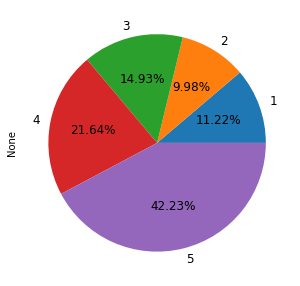

In [ ]:
data_label = data['rate']
data_label = pd.DataFrame(data_label, columns=['rate']).groupby('rate').size()
data_label.plot.pie(figsize=(5, 5), autopct="%.2f%%", fontsize=12)

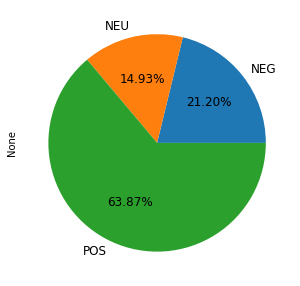

In [ ]:
data_label = data['label']
data_label = pd.DataFrame(data_label, columns=['label']).groupby('label').size()
data_label.plot.pie(figsize=(5, 5), autopct="%.2f%%", fontsize=12)

In [ ]:
data.groupby('label').describe()

rate                                             
         count      mean       std  min  25%  50%  75%  max
label                                                      
NEG     6669.0  1.470835  0.499186  1.0  1.0  1.0  2.0  2.0
NEU     4698.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0
POS    20093.0  4.661225  0.473305  4.0  4.0  5.0  5.0  5.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8aa54ba110>]],
      dtype=object)

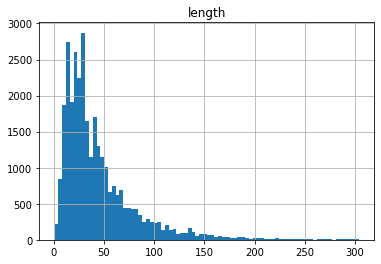

In [ ]:
data['length'] = data['comment'].apply(len)
data.hist(column='length', bins=80)

In [ ]:
data = data.values
print(data.shape)
comment = data[:,0]
label = data[:,1]
rate = data[:,2]
print(comment[:5])
print(label[:20])
print(rate[:20])

(31460, 4)
['Áo bao đẹp ạ!!' 'Tuyệt vời !' '2day ao khong giong trong.'
 'Mùi thơm,bôi lên da mềm da.' 'Vải đẹp, dày dặn.']
['POS' 'POS' 'NEG' 'POS' 'POS' 'POS' 'POS' 'POS' 'POS' 'NEG' 'POS' 'NEU'
 'POS' 'POS' 'POS' 'POS' 'POS' 'POS' 'POS' 'NEG']
[5 5 1 5 5 5 5 4 5 2 5 3 5 5 4 5 4 5 5 2]


In [ ]:
def create_stopwordlist():
    f = codecs.open('data/vietnamese-stopwords.txt', encoding='utf-8')
    data = []
    null_data = []
    for i, line in enumerate(f):
        line = repr(line)
        line = line[1:len(line)-3]
        data.append(line)
    return data

In [ ]:
stopword_vn = create_stopwordlist()

In [ ]:
print(stopword_vn)

['a lô', 'a ha', 'ai', 'ai ai', 'ai nấy', 'ai đó', 'alô', 'amen', 'anh', 'anh ấy', 'ba', 'ba ba', 'ba bản', 'ba cùng', 'ba họ', 'ba ngày', 'ba ngôi', 'ba tăng', 'bao giờ', 'bao lâu', 'bao nhiêu', 'bao nả', 'bay biến', 'biết', 'biết bao', 'biết bao nhiêu', 'biết chắc', 'biết chừng nào', 'biết mình', 'biết mấy', 'biết thế', 'biết trước', 'biết việc', 'biết đâu', 'biết đâu chừng', 'biết đâu đấy', 'biết được', 'buổi', 'buổi làm', 'buổi mới', 'buổi ngày', 'buổi sớm', 'bà', 'bà ấy', 'bài', 'bài bác', 'bài bỏ', 'bài cái', 'bác', 'bán', 'bán cấp', 'bán dạ', 'bán thế', 'bây bẩy', 'bây chừ', 'bây giờ', 'bây nhiêu', 'bèn', 'béng', 'bên', 'bên bị', 'bên có', 'bên cạnh', 'bông', 'bước', 'bước khỏi', 'bước tới', 'bước đi', 'bạn', 'bản', 'bản bộ', 'bản riêng', 'bản thân', 'bản ý', 'bất chợt', 'bất cứ', 'bất giác', 'bất kì', 'bất kể', 'bất kỳ', 'bất luận', 'bất ngờ', 'bất nhược', 'bất quá', 'bất quá chỉ', 'bất thình lình', 'bất tử', 'bất đồ', 'bấy', 'bấy chầy', 'bấy chừ', 'bấy giờ', 'bấy lâu', 'bấy lâ

In [ ]:
sentences = [word_tokenize(sent) for sent in comment if sent not in stopword_vn]

In [ ]:
print(sentences[:10])

[['Áo bao', 'đẹp', 'ạ', '!', '!'], ['Tuyệt vời', '!'], ['2', 'day', 'ao', 'khong', 'giong', 'trong', '.'], ['Mùi thơm', ',', 'bôi', 'lên da', 'mềm', 'da', '.'], ['Vải', 'đẹp', ',', 'dày dặn', '.'], ['Hàng', 'rất', 'đẹp', ',', 'rất', 'chi là', 'ưng ý', '.'], ['Chất lượng', 'sản phẩm', 'tốt', ',', 'date', 'dài', '.'], ['Ăn nói', 'và', 'thái độ', 'phục vụ', 'tốt', '.'], ['Đóng gói', 'sản phẩm', 'chắc chắn', '.'], ['tất', 'sờn', 'hết', 'ca', 'chưa', 'dùng', 'mà', 'vay', 'r', '.']]


In [ ]:
'''tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
# kiểm tra từ điểm tạo trong tokenizer
#print(tokenizer.word_index)

In [ ]:
'''#texts_to_matrix(tokenizer, texts, mode = c("binary", "count", "tfidf", "freq"))
X = tokenizer.texts_to_matrix(sentences,mode='binary')
print('binary: ',X)

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True,split=' ')
tokenizer.fit_on_texts(sentences)
X = tokenizer.texts_to_sequences(sentences)
X = pad_sequences(X)
print(X[:5])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0 1919    5
    50   32   32]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   12   32]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [ ]:
#Encode labels ở True_label 1,2,3,4,5 tương ứng thành 0,1,2,3,4
le = preprocessing.LabelEncoder()
label = le.fit_transform(label)
print(label)

[2 2 0 ... 2 2 2]


In [ ]:
list(le.inverse_transform([0, 1, 2]))

['NEG', 'NEU', 'POS']

In [ ]:
Y = tf.keras.utils.to_categorical(label)

# Wandb setting

In [ ]:
#@title Login WandbWandb { display-mode: "form" }
# Log in to your W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                            test_size=0.2, random_state=36)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_train[:5])
print(X.shape)

(25168, 87)
(6292, 87)
(25168, 3)
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
(31460, 87)


In [ ]:
'''y_train = to_categorical(y_train)
print(y_train[:5])

In [ ]:
vocabulary_size=len(tokenizer.word_index)+1
print('Vocab count',vocabulary_size)

Vocab count 8224


In [ ]:
embed_dim = 128
hidden_size = 200
def Model():
    model = models.Sequential()
    model.add(layers.Embedding(vocabulary_size, embed_dim, input_length = X.shape[1]))
    model.add(layers.LSTM(hidden_size,return_sequences = True))
    model.add(layers.LSTM(hidden_size))
    #model.add(layers.SimpleRNN(128))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(128,activation='sigmoid'))
    model.add(layers.Dense(3,activation='softmax'))

    return model 

In [ ]:
#@title Config wandb
#wandb.init(project="vsa", entity="nvlong")
# Initialize wandb with your project name
run = wandb.init(project='vsa', entity="nvlong", name="lstm3",
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.005,
                     "epochs": 50,
                     "batch_size": 32,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "LSTM",
                     "dataset": "data-vietnames-sentiment-analyst"
                 })

wandb: Currently logged in as: nvlong (use `wandb login --relogin` to force relogin)


In [ ]:
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()

model = Model()
model.summary()

optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 87, 128)           1052672   
_________________________________________________________________
lstm (LSTM)                  (None, 87, 200)           263200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 128)               25728     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 1,679,299
Trainable params: 1,679,299
Non-trainable params: 0
______________________________________________

In [ ]:
# We train with our beloved model.fit
# Notice WandbCallback is used as a regular callback
# We again use config
_ = model.fit(X_train, y_train,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=(X_test, y_test),
          callbacks=[WandbCallback()])

787/787 [==============================] - 38s 49ms/step - loss: 0.2673 - acc: 0.9034 - val_loss: 0.7442 - val_acc: 0.7707
Epoch 43/50
787/787 [==============================] - 38s 49ms/step - loss: 0.2707 - acc: 0.9021 - val_loss: 0.7288 - val_acc: 0.7721
Epoch 44/50
787/787 [==============================] - 38s 49ms/step - loss: 0.2693 - acc: 0.9005 - val_loss: 0.7028 - val_acc: 0.7689
Epoch 45/50
787/787 [==============================] - 38s 49ms/step - loss: 0.2649 - acc: 0.9031 - val_loss: 0.7127 - val_acc: 0.7656
Epoch 46/50
787/787 [==============================] - 38s 49ms/step - loss: 0.2826 - acc: 0.8960 - val_loss: 0.6861 - val_acc: 0.7719
Epoch 47/50
787/787 [==============================] - 38s 49ms/step - loss: 0.2775 - acc: 0.8982 - val_loss: 0.7186 - val_acc: 0.7678
Epoch 48/50
787/787 [==============================] - 38s 49ms/step - loss: 0.2624 - acc: 0.9039 - val_loss: 0.7761 - val_acc: 0.7618
Epoch 49/50
787/787 [==============================] - 38s 48ms/ste

In [ ]:
#@title Report train { display-mode: "form" }
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Error Rate: ', round((1 - accuracy) * 100, 2))

# With wandb.log, we can easily pass in metrics as key-value pairs.
wandb.log({'Test Error Rate': round((1 - accuracy) * 100, 2)})

run.finish()

197/197 [==============================] - 4s 21ms/step - loss: 0.7504 - acc: 0.7651
Test Error Rate:  23.49


Test Error Rate,▁
acc,▁▃▄▄▆▆▆▇▇▇▇▇▇███████████████▆▆▇▇▇▇▇▇▆▆▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▂▃▃▃▃▃▃▂▂
val_acc,▇█▆▆▇▆▅▅▅▅▄▃▃▃▃▂▃▃▃▂▃▃▁▂▂▂▁▂▁▂▁▂▃▃▃▂▃▂▁▂
val_loss,▁▁▁▁▂▃▃▄▅▆▅▆▆▆▆▆▇▆▆▆█▇▇█▇▇██▄▅▅▆▅▅▅▅▄▅▆▅
Test Error Rate,23.49
acc,0.90516
best_epoch,1
best_val_loss,0.51056
epoch,49


# Test from dataset and report

In [ ]:
#test
preds = model.predict(X_test, verbose = 1)

197/197 [==============================] - 28s 137ms/step


In [ ]:
#show result scores
predict_labels = preds.argmax(axis=-1)
true_labels=y_test.argmax(axis=-1)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(true_labels, predict_labels)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(true_labels, predict_labels, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(true_labels, predict_labels, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(true_labels, predict_labels, average='micro')
print('F1 score: %f' % f1)

Accuracy: 0.765099
Precision: 0.765099
Recall: 0.765099
F1 score: 0.765099


In [ ]:
print(classification_report(true_labels, predict_labels))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70      1373
           1       0.34      0.35      0.35       925
           2       0.87      0.90      0.88      3994

    accuracy                           0.77      6292
   macro avg       0.65      0.64      0.64      6292
weighted avg       0.76      0.77      0.76      6292



# Test from external data 

In [ ]:
model = load_model("wandb/latest-run/files/model-best.h5")

In [ ]:
#Test du lieu ben ngoai
def pre_process(review):
  filename = 'data/data - data.csv'
  data = pd.read_csv(filename, encoding='utf-8')
  data.comment[0] = review

  tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True,split=' ')
  tokenizer.fit_on_texts(data.comment)
  text = tokenizer.texts_to_sequences(data.comment)
  text = pad_sequences(text)
  
  return text[:1]



In [ ]:
review = 'tất sờn hết ca chưa dùng mà vay r'
review = pre_process(review)
print(review)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  355 2556
   158 1070  121  164   44  726  371]]


In [ ]:
result = model.predict(review, verbose = 1)

1/1 [==============================] - 0s 26ms/step


In [ ]:
pre = np.argmax(result)
print("Label predict: ", pre)

Label predict:  0


In [ ]:
review = 'Hàng rất đẹp, rất chi là ưng ý.'
review = pre_process(review)
#print(review)

result = model.predict(review, verbose = 1)

pre = np.argmax(result)
print("Label predict: ", pre)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


1/1 [==============================] - 0s 26ms/step
Label predict:  1


In [ ]:
review = 'Quá đỉnh, cảnh quan rất tuyệt vời.'
review = pre_process(review)
#print(review)

result = model.predict(review, verbose = 1)

pre = np.argmax(result)
print("Label predict: ", pre)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


1/1 [==============================] - 0s 26ms/step
Label predict:  2
